# Effect of input representations on learning Jupyter Notebook
### ICML 2025 Workshop on Methods and Opportunities at Small Scale
### May, 2025

This is the accompanying tutorial notebook for the paper *Permutations as a testbed for studying the effect of input representations on learning*. In this notebook, we explain how to generate different representations of permutations, as well as how to compute various statistics on this permutation data for use in downstream classification tasks. We provide the code to generate two example permutation datasets and show how to train a simple MLP classification model on the data. The MLP model performance between the two generated datasets are very different, supporting our interest in the impact that data representation choice can have on learning
outcomes.

In explaining the specific representations and statistics used to generate results in the paper, we aim to make permutation datasets more readily suited for continuing research in this direction. 

## Installation:

Since SageMath is not pip installable, we need to use conda. The cells below assume you are running this in google colab. 

Alternatively, to run this notebook locally using a conda environment:
```
conda create -n permutation sage jupyter ipykernel python=3.11
conda activate permutation
python -m pip install torch tqdm
python -m ipykernel install --user --name permutation --display-name permutation
```

In [ ]:
#This cell took between 5 and 30 minutes to execute
!wget -q https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -p /content/miniconda

import os
os.environ['PATH'] = "/content/miniconda/bin:" + os.environ['PATH']

!conda config --add channels conda-forge --quiet
!conda install sage python=3.11 -y --quiet

In [ ]:
import sys
sage_site_packages = '/content/miniconda/lib/python3.11/site-packages'
if sage_site_packages not in sys.path:
    sys.path.insert(0, sage_site_packages)

from sage.all import *

In [62]:
# Import relevant packages
import numpy as np
import math
import os
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

# How to generate different representations of permutations

We begin with an example permutation in one-line notation.

In [63]:
x = Permutation([2,5,3,4,1]) 
print(f'Original permutation (one-line notation): {x}')

Original permutation (one-line notation): [2, 5, 3, 4, 1]


### Permutation matrix
The permutation matrix representation of a permutation is the one-hot encoding of the one line notation, so the $(i, j)$th entry of the permutation matrix is 1 precisely when $\sigma(i) = j$, and 0 otherwise. The permutation matrix representation of $2 4 3 1$ is:
$$
\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0
\end{pmatrix}
$$

In [10]:
permutation_matrix = x.to_matrix()
print(permutation_matrix)

[0 0 0 0 1]
[1 0 0 0 0]
[0 0 1 0 0]
[0 0 0 1 0]
[0 1 0 0 0]


### Inversion vector
The inversion vector of a permutation is the vector where the $i$th entry gives the number of $j > i$ that appear before $i$ in the permutation. The inversion vector of the permutation 2 5 3 4 1 is $(4, 0, 1, 1, 0)$.

In [11]:
inversion_vector = x.to_inversion_vector()
print(inversion_vector)

[4, 0, 1, 1, 0]


### Lehmer cocode
The Lehmer cocode is also based on inversions, but the $i$th entry is the number of $j < i$ with $\sigma(j) > \sigma(i)$. The Lehmer cocode of the permutation is 2 5 3 4 1 is $(0, 0, 1, 1, 4)$. Note that applying the permutation $\sigma$ to the Lehmer cocode gives the inversion vector. 

In [29]:
lehmer_cocode = x.to_lehmer_cocode()
print(lehmer_cocode)

[0, 0, 1, 1, 4]


### Major code 
The *major code* is the vector $(m_1-m_2, m_2 - m_3, \ldots, m_n)$, where $m_i$ is the sum of all of the descents of the permutation (also called the major index) obtained by erasing letters smaller than $i$ from the permutation. For example, for the permutation $2 5 3 4 1$, $m_1 = 6$, $m_2 =2$, $m_3 = 2$ and $m_4 = m_5 = 0$, so the major code is $(4, 1, 0, 1, 0)$.

In [30]:
major_code = x.to_major_code()
print(major_code)

[4, 1, 0, 1, 0]


### Lexicographically minimal reduced word
Finally, we also represent permutations using the reduced word for the permutation that is smallest in lexicographic order. We pad with zeros so that the reduced words are all the same length. 

In [96]:
def compute_reduced_word_lexmin(x):
    n = max(x)
    L = Permutation(x).reduced_word_lexmin()
    if len(L) < math.comb(n, 2):
        newL = L + [0]*(math.comb(n, 2) - len(L))
        return np.array(newL)
    else:
        return np.array(L)

reduced_word_lexmin = compute_reduced_word_lexmin(x)
print(reduced_word_lexmin)

[1 2 3 4 3 2 0 0 0 0]


# How to compute statistics on permutation data

The permutations module from SAGE math is very useful to quickly compute statistics of permutations. Start with an example permutation, x.


In [32]:
print(f'Original permutation (one-line notation): {x}')

Original permutation (one-line notation): [2, 5, 3, 4, 1]


### Length
The length (or Coxeter length) of a permutation is the number of inversions of the permutation, or, equivalently, the length of a reduced word for the permutation. 
Note that the length of the permutation is simply the sum of the inversion vector or the Lehmer cocode.

In [33]:
length = x.length()
print(length)

6


### Permutation parity
The parity of a permutation is the even/oddness of its length. A permutation is even if and only if its length is an even number. 
Note that the parity of a permutation can be computed from the inversion vector or the Lehmer cocode by computing the parity of its sum. 


In [34]:
parity = x.is_even()
print(parity)

True


### Major index
The major index of a permutation is the sum of all of the descents. 
Note that the major index is the sum of the major code. 

In [35]:
major_index = x.major_index()
print(major_index)

6


### Number of descents

In [36]:
num_descents = x.number_of_descents()
print(num_descents)

2


### Number of fixed points
The number of fixed points in a permutation are the number of values $i$ such that $\sigma(i) = i$.
Note that the number of fixed points in the permutation is the trace of the permutation matrix. 

In [37]:
num_fixed_points = len(x.fixed_points())
print(num_fixed_points)

2


### Number of peaks
A peak of a permutation is an integer $i$ such that $\sigma(i-1) < \sigma(i)$ and $\sigma(i) > \sigma(i+1)$.


In [38]:
num_peaks = x.number_of_peaks()
print(num_peaks)

2


### Longest increasing subsequence length
The longest increasing subsequence of $\sigma$ is the longest sequence $i_{1} < i_{2} < \cdots < i_{n}$ with $\sigma_{i_{1}} < \sigma_{i_{2}} < \cdots < \sigma_{i_{n}}$. 


In [39]:
longest_inc_subsequence_len = x.longest_increasing_subsequence_length()
print(longest_inc_subsequence_len)

3


### Number of nestings
A nesting of a permutation is a pair $(i, j)$ such that $j < i < \sigma(i) < \sigma(j)$ or $\sigma(j) < \sigma(i) \leq i < j$. This definition comes from the permutation diagram.


In [40]:
def count_nestings(pi):
    '''
    Code from https://www.findstat.org/StatisticsDatabase/St000223/
    '''
    ne = 0
    n = len(pi)
    for i in range(n):
        for j in range(n):
            if (j < i < pi[i] < pi[j] or pi[j] < pi[i] <= i < j):
                ne = ne+1
    return ne

number_nestings = count_nestings(x)
print(number_nestings)

2


### Order
The order of a permutation is the smallest positive integer $m$ so that applying the permutation $m$ times is equivalent to the identity permutation. The order of a permutation is the least common multiple of the lengths of its cycles. 


In [41]:
def compute_order(x):
    return lcm(x.cycle_type())

order = compute_order(x)
print(order)

3


### Number of cycles
The number of cycles is the number of cycles in the representation of the permutation as a product of disjoint cycles. (Including cycles of length 1). 


In [42]:
def count_cycles(x):
    return len(x.cycle_type())

num_cycles = count_cycles(x)
print(num_cycles)

3


### Cardinality of the support
The support of a permutation are the indices that appear in a reduced word of that permutation (which are independent of the reduced word chosen). The cardinality of the support is the number of distinct indices in the support.  


In [43]:
def compute_support_cardinality(x):
    '''
    Code from https://www.findstat.org/StatisticsDatabase/St000019/
    '''
    return len(set(x.reduced_word()))

support_cardinality = compute_support_cardinality(x)
print(support_cardinality)

4


### Number of stack sorts
The number of stack sorts needed to sort a permutation. A permutation is *stack sortable* if it can be sorted by the following algorithm: 

- Initialize an empty stack and empty final output
- For each element $x$ in the input permutation: (a) while the stack is nonempty and $x$ is larger than the last item added to the stack, pop this item from the stack to the output (b) put $x$ onto the stack
- If the stack is nonempty, add remaining stack to the output. 

When we apply this algorithm to the permutation $2 5 3 4 1$, we get the permutation $2 3 1 4 5$. After two more stack sorts we get the identity permutation, so the number of stack sorts needed to sort the permutation is 3. 


In [44]:
def stack_sort(x):
    '''
    Code from https://www.findstat.org/StatisticsDatabase/St000028/
    '''
    stack = []
    result = []
    for e in x:
        while stack and e > stack[-1]:
            result += [stack.pop()]
        stack.append(e)
    while stack:
        result += [stack.pop()]
    return Permutation(result)

def count_stack_sorts(x):
    '''
    Code from https://www.findstat.org/StatisticsDatabase/St000028/
    '''
    i = 0
    id = Permutations(x.size()).identity()
    while x != id:
        x = stack_sort(x)
        i += 1
    return i

num_stack_sorts = count_stack_sorts(x)
print(num_stack_sorts)

3


### Further reading

For those interested in exploring more permutation statistics and representations, please see:
- [SageMath Permutation Documentation](https://doc.sagemath.org/html/en/reference/combinat/sage/combinat/permutation.html): Comprehensive documentation of permtuation methods in SageMath 
- [FindStat combinatorial database](https://www.findstat.org/StatisticsDatabase/): A database with over 400 permutation statistics with code implementatison and references: 

# How to train a MLP to classify permutations by a specified statistic

First, we select a permutation representation, a statistic to classify by, and a value of $N$.

In [99]:
representation = 'inversion_vector'
statistic = 'major_index'
N = 7

Now, we generate a dataset of permutation samples from $S_{N}$.

Define a function to convert the representations into one-hot-encoded and then flattened vectors.

In [66]:
def one_hot_encode(sequences_torch):
    """
    One-hot encodes the elements for a list of permutations.

    Args:
        sequences_torch (list): A list of torch vectors of permutations to encode.
        
    Returns:
        list: a list of one-hot encoded representations of the permutations flattened in the input vector.
    """

    # Get the maximum value of all of the entries
    if sequences_torch[0].ndim == 1:
        max_val = float('-inf')  # Initialize with negative infinity
        for seq in sequences_torch:
            for entry in seq:
                if entry > max_val:
                    max_val = entry

    # Convert tensor to numpy for processing if needed
    if not isinstance(sequences_torch, np.ndarray):
        sequences_torch = sequences_torch.numpy()
    else:
        sequences_torch = sequences_torch
        
    permutations_one_hot_encoded = []
    for permutation in sequences_torch:
        if np.array(permutation).ndim == 1:
            
            unique_elements = np.unique(permutation)
            encoding_matrix = np.eye(max_val+1)
            element_to_index = {element: index for index, element in enumerate(np.array(range(max_val+1)))}
            encoded_vector = np.array([encoding_matrix[element_to_index[element]] for element in permutation]).flatten()
            
        elif permutation.ndim == 2:
            encoded_vector = permutation.flatten()
            
        permutations_one_hot_encoded.append(encoded_vector)
        
    return torch.tensor(np.array(permutations_one_hot_encoded))

In [82]:
S = Permutations(N)
data_lst = [np.array(x.to_inversion_vector()) for x in S]
labels_lst = [np.array(x.major_index()) for x in S]

In [84]:
sequences_torch = torch.from_numpy(np.array(data_lst))
labels_torch = torch.from_numpy(np.array(labels_lst)).type(torch.LongTensor)

output_size = max(labels_torch)+1
print(f"DATASET # of classes is: {output_size}")

# Use one hot encoding for all permutation inputs
sequences_torch = one_hot_encode(sequences_torch)
input_size = sequences_torch[0].shape[0]

DATASET # of classes is: 22


Do a train test split and define tensor datasets using PyTorch.

In [85]:
np.random.seed(42)
torch.manual_seed(42)

split = 0.7
ds_size = int(len(sequences_torch))
random_idx = list(range(len(sequences_torch)))
np.random.shuffle(random_idx)

sequences_torch_train = sequences_torch[random_idx][:math.ceil(ds_size*split)].float()
labels_torch_train = labels_torch[random_idx][:math.ceil(ds_size*split)]

sequences_torch_test = sequences_torch[random_idx][math.ceil(ds_size*split):].float()
labels_torch_test = labels_torch[random_idx][math.ceil(ds_size*split):]

trainset = torch.utils.data.TensorDataset(sequences_torch_train, labels_torch_train)
testset = torch.utils.data.TensorDataset(sequences_torch_test, labels_torch_test)


Specify model parameters:

In [86]:
device = 'cuda'
BATCH_SIZE = 32
LR = 0.001
DROPOUT = 0.1
WEIGHT_DECAY = 0.0001
EPOCHS = 200

Now we define the MLP model architecture.

In [87]:
class FeedForward(nn.Module):
    def __init__(self, 
                 dimensions,
                 num_classes,
                 dropout_rate = 0.0):
        super().__init__()
        self.linear_layers = nn.ModuleList([ nn.Linear(dimensions[i], dimensions[i+1]) for i in range(len(dimensions)-1) ]
                                            )
        self.classification = nn.Linear(dimensions[-1], num_classes)
        self.relu = nn.ReLU()

        self.drop1 = nn.Dropout(dropout_rate)
        self.dropout_rate = dropout_rate
    def forward(self, x):
        for layer in self.linear_layers:
            x = self.relu(layer(x) )
            x = self.drop1(x)

        x = self.classification(x)

        return x

Define functions to train the MLP.

In [88]:
def evaluate_one_epoch(model, testloader, criterion, device):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in testloader:
            sequences, labels = sequences.float().to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = outputs.max(1)
            
            loss = criterion(outputs, labels)
           
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item() * labels.size(0)

            # Collecting predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples

    return avg_loss, accuracy

In [89]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=100, bs=32, when_to_print=10):
    
    all_train_loss, all_train_acc, all_test_loss, all_test_acc, all_test_f1 = [],[], [], [], []
    best_test_acc = 0
    best_epoch = 0
    best_weights = None
    
    for ep in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for sequences, labels in tqdm(trainloader, desc=f"Epoch {ep+1}/{epochs}"):
            sequences, labels = sequences.float().to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(sequences)
            loss = criterion(output, labels)
            
            # backprop and optimize
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            train_correct += predicted.eq(labels).sum().item()
            train_total += labels.size(0)
            train_loss += loss.item() * labels.size(0)

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / train_total
        all_train_acc.append(train_acc)
        all_train_loss.append(avg_train_loss)

        if ep % when_to_print == 0:
            print(f"Epoch {ep}: Train Acc: {train_acc:.2%}, Train Loss: {avg_train_loss:.4f}")

        model.eval()
        avg_test_loss, test_acc = evaluate_one_epoch(model, testloader, criterion, device)

        all_test_acc.append(test_acc)
        all_test_loss.append(avg_test_loss)

        if ep % when_to_print == 0:
            print(f"Test Acc: {test_acc:.2%}, Test Loss: {avg_test_loss:.4f}")
                
    return all_train_loss, all_train_acc, all_test_loss, all_test_acc

Now train the model.

In [90]:
print(f'Training the MLP for {representation}, {statistic}...')
best_accuracy = 0

# Create and train the model with the specified hyperparameters
model = FeedForward(dimensions=[input_size, 128, 128, 64], num_classes=output_size, dropout_rate=DROPOUT)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# Train the model
all_train_loss, all_train_acc, all_test_loss, all_test_acc = train( model, trainloader, testloader, criterion, 
                                                                   optimizer, epochs=EPOCHS, bs=BATCH_SIZE, when_to_print=10)


Training the MLP for inversion_vector, major_index...


Epoch 1/200: 100%|██████████| 111/111 [00:00<00:00, 471.95it/s]


Epoch 0: Train Acc: 9.78%, Train Loss: 2.7268
Test Acc: 13.43%, Test Loss: 2.5439


Epoch 11/200: 100%|██████████| 111/111 [00:00<00:00, 479.78it/s]


Epoch 10: Train Acc: 40.02%, Train Loss: 1.5018
Test Acc: 38.76%, Test Loss: 1.4371


Epoch 21/200: 100%|██████████| 111/111 [00:00<00:00, 480.14it/s]


Epoch 20: Train Acc: 64.91%, Train Loss: 0.9382
Test Acc: 70.70%, Test Loss: 0.8534


Epoch 31/200: 100%|██████████| 111/111 [00:00<00:00, 479.71it/s]


Epoch 30: Train Acc: 78.83%, Train Loss: 0.5929
Test Acc: 84.99%, Test Loss: 0.4878


Epoch 41/200: 100%|██████████| 111/111 [00:00<00:00, 479.43it/s]


Epoch 40: Train Acc: 85.40%, Train Loss: 0.3956
Test Acc: 92.13%, Test Loss: 0.2723


Epoch 51/200: 100%|██████████| 111/111 [00:00<00:00, 479.14it/s]


Epoch 50: Train Acc: 90.59%, Train Loss: 0.2746
Test Acc: 95.90%, Test Loss: 0.1699


Epoch 61/200: 100%|██████████| 111/111 [00:00<00:00, 479.05it/s]


Epoch 60: Train Acc: 93.06%, Train Loss: 0.2121
Test Acc: 97.09%, Test Loss: 0.1033


Epoch 71/200: 100%|██████████| 111/111 [00:00<00:00, 478.94it/s]


Epoch 70: Train Acc: 94.67%, Train Loss: 0.1761
Test Acc: 97.62%, Test Loss: 0.0829


Epoch 81/200: 100%|██████████| 111/111 [00:00<00:00, 479.05it/s]


Epoch 80: Train Acc: 95.46%, Train Loss: 0.1339
Test Acc: 99.07%, Test Loss: 0.0482


Epoch 91/200: 100%|██████████| 111/111 [00:00<00:00, 474.46it/s]


Epoch 90: Train Acc: 96.23%, Train Loss: 0.1195
Test Acc: 98.94%, Test Loss: 0.0429


Epoch 101/200: 100%|██████████| 111/111 [00:00<00:00, 478.26it/s]


Epoch 100: Train Acc: 96.60%, Train Loss: 0.1102
Test Acc: 98.94%, Test Loss: 0.0338


Epoch 111/200: 100%|██████████| 111/111 [00:00<00:00, 478.89it/s]


Epoch 110: Train Acc: 97.08%, Train Loss: 0.0950
Test Acc: 99.47%, Test Loss: 0.0336


Epoch 121/200: 100%|██████████| 111/111 [00:00<00:00, 478.18it/s]


Epoch 120: Train Acc: 97.82%, Train Loss: 0.0751
Test Acc: 99.47%, Test Loss: 0.0266


Epoch 131/200: 100%|██████████| 111/111 [00:00<00:00, 473.68it/s]


Epoch 130: Train Acc: 97.73%, Train Loss: 0.0755
Test Acc: 99.21%, Test Loss: 0.0269


Epoch 141/200: 100%|██████████| 111/111 [00:00<00:00, 477.97it/s]


Epoch 140: Train Acc: 97.17%, Train Loss: 0.0797
Test Acc: 99.47%, Test Loss: 0.0223


Epoch 151/200: 100%|██████████| 111/111 [00:00<00:00, 478.64it/s]


Epoch 150: Train Acc: 98.24%, Train Loss: 0.0647
Test Acc: 99.54%, Test Loss: 0.0190


Epoch 161/200: 100%|██████████| 111/111 [00:00<00:00, 477.90it/s]


Epoch 160: Train Acc: 98.27%, Train Loss: 0.0626
Test Acc: 99.80%, Test Loss: 0.0118


Epoch 171/200: 100%|██████████| 111/111 [00:00<00:00, 473.15it/s]


Epoch 170: Train Acc: 98.55%, Train Loss: 0.0491
Test Acc: 99.87%, Test Loss: 0.0107


Epoch 181/200: 100%|██████████| 111/111 [00:00<00:00, 474.73it/s]


Epoch 180: Train Acc: 97.93%, Train Loss: 0.0650
Test Acc: 99.93%, Test Loss: 0.0099


Epoch 191/200: 100%|██████████| 111/111 [00:00<00:00, 478.31it/s]


Epoch 190: Train Acc: 98.75%, Train Loss: 0.0377
Test Acc: 99.80%, Test Loss: 0.0134


Epoch 200/200: 100%|██████████| 111/111 [00:00<00:00, 477.55it/s]


Plot the results by loss and accuracy.

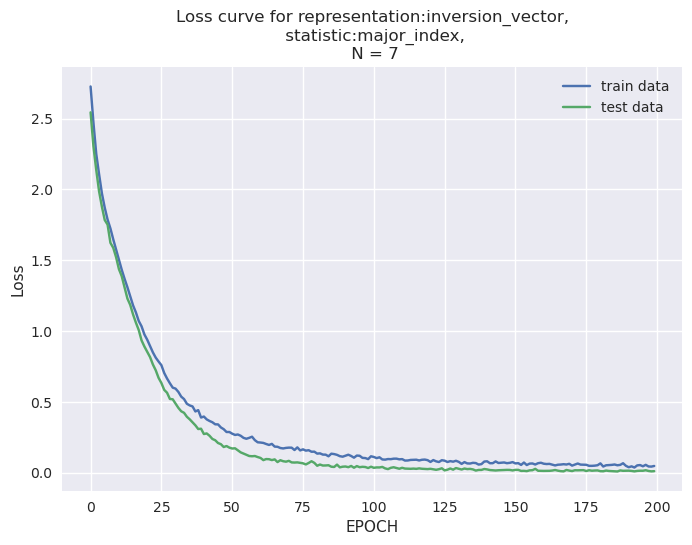

In [91]:
plt.style.use("seaborn-v0_8")
plt.title(f'Loss curve for representation:{representation},\n statistic:{statistic},\n N = {N}')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.plot(all_train_loss, label = 'train data')
plt.plot(all_test_loss, label= 'test data')
plt.legend()
plt.show()

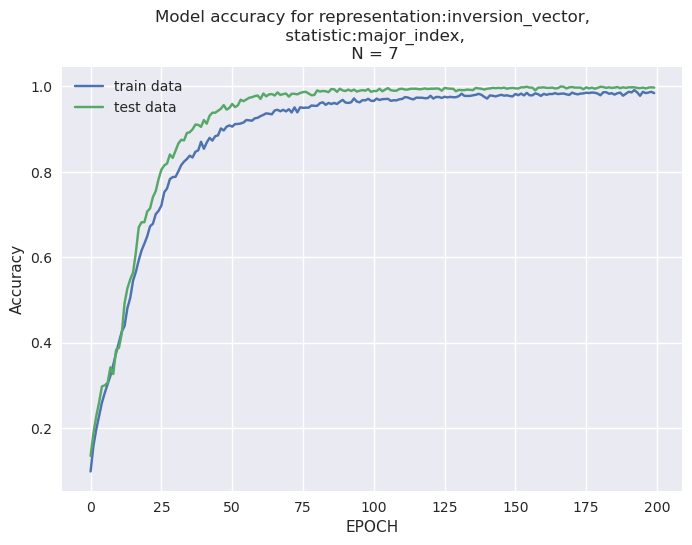

In [92]:
plt.title(f'Model accuracy for representation:{representation},\n statistic:{statistic},\n N = {N}')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(all_train_acc, label = 'train data')
plt.plot(all_test_acc, label= 'test data')
plt.legend()
plt.show()

### Now train a model using a different input representation
We use a permutation dataset of the same permutations (from $S_N$) to classify by major code.


In [100]:
representation = 'reduced_word_lexmin'

In [101]:
S = Permutations(N)
data_lst = [np.array(compute_reduced_word_lexmin(x)) for x in S]
labels_lst = [np.array(x.major_index()) for x in S]

In [104]:
sequences_torch = torch.from_numpy(np.array(data_lst))
labels_torch = torch.from_numpy(np.array(labels_lst)).type(torch.LongTensor)

output_size = max(labels_torch)+1
print(f"DATASET # of classes is: {output_size}")

# Use one hot encoding for all permutation inputs
sequences_torch = one_hot_encode(sequences_torch)
input_size = sequences_torch[0].shape[0]

DATASET # of classes is: 22


In [105]:
np.random.seed(42)
torch.manual_seed(42)

split = 0.7
ds_size = int(len(sequences_torch))
random_idx = list(range(len(sequences_torch)))
np.random.shuffle(random_idx)

sequences_torch_train = sequences_torch[random_idx][:math.ceil(ds_size*split)].float()
labels_torch_train = labels_torch[random_idx][:math.ceil(ds_size*split)]

sequences_torch_test = sequences_torch[random_idx][math.ceil(ds_size*split):].float()
labels_torch_test = labels_torch[random_idx][math.ceil(ds_size*split):]

trainset = torch.utils.data.TensorDataset(sequences_torch_train, labels_torch_train)
testset = torch.utils.data.TensorDataset(sequences_torch_test, labels_torch_test)

In [106]:
print(f'Training the MLP for {representation}, {statistic}...')
best_accuracy = 0

# Create and train the model with the specified hyperparameters
model = FeedForward(dimensions=[input_size, 128, 128, 64], num_classes=output_size, dropout_rate=DROPOUT)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# Train the model
all_train_loss, all_train_acc, all_test_loss, all_test_acc = train( model, trainloader, testloader, criterion, 
                                                                   optimizer, epochs=EPOCHS, bs=BATCH_SIZE, when_to_print=10)


Training the MLP for reduced_word_lexmin, major_index...


Epoch 1/200: 100%|██████████| 111/111 [00:00<00:00, 471.18it/s]


Epoch 0: Train Acc: 10.74%, Train Loss: 2.7192
Test Acc: 12.10%, Test Loss: 2.5495


Epoch 11/200: 100%|██████████| 111/111 [00:00<00:00, 476.43it/s]


Epoch 10: Train Acc: 15.90%, Train Loss: 2.1598
Test Acc: 17.26%, Test Loss: 2.2456


Epoch 21/200: 100%|██████████| 111/111 [00:00<00:00, 476.41it/s]


Epoch 20: Train Acc: 21.63%, Train Loss: 1.9348
Test Acc: 17.06%, Test Loss: 2.1860


Epoch 31/200: 100%|██████████| 111/111 [00:00<00:00, 475.96it/s]


Epoch 30: Train Acc: 29.25%, Train Loss: 1.7174
Test Acc: 18.39%, Test Loss: 2.1291


Epoch 41/200: 100%|██████████| 111/111 [00:00<00:00, 475.64it/s]


Epoch 40: Train Acc: 38.49%, Train Loss: 1.4984
Test Acc: 25.53%, Test Loss: 1.9933


Epoch 51/200: 100%|██████████| 111/111 [00:00<00:00, 475.80it/s]


Epoch 50: Train Acc: 46.09%, Train Loss: 1.3019
Test Acc: 27.98%, Test Loss: 2.0551


Epoch 61/200: 100%|██████████| 111/111 [00:00<00:00, 476.04it/s]


Epoch 60: Train Acc: 51.84%, Train Loss: 1.1824
Test Acc: 32.14%, Test Loss: 2.0477


Epoch 71/200: 100%|██████████| 111/111 [00:00<00:00, 476.54it/s]


Epoch 70: Train Acc: 55.95%, Train Loss: 1.0674
Test Acc: 32.14%, Test Loss: 2.1111


Epoch 81/200: 100%|██████████| 111/111 [00:00<00:00, 476.19it/s]


Epoch 80: Train Acc: 59.92%, Train Loss: 0.9770
Test Acc: 34.13%, Test Loss: 2.0908


Epoch 91/200: 100%|██████████| 111/111 [00:00<00:00, 476.53it/s]


Epoch 90: Train Acc: 64.03%, Train Loss: 0.8874
Test Acc: 35.98%, Test Loss: 2.1436


Epoch 101/200: 100%|██████████| 111/111 [00:00<00:00, 471.85it/s]


Epoch 100: Train Acc: 68.31%, Train Loss: 0.8010
Test Acc: 35.52%, Test Loss: 2.2599


Epoch 111/200: 100%|██████████| 111/111 [00:00<00:00, 477.21it/s]


Epoch 110: Train Acc: 72.22%, Train Loss: 0.7324
Test Acc: 40.54%, Test Loss: 2.0601


Epoch 121/200: 100%|██████████| 111/111 [00:00<00:00, 476.97it/s]


Epoch 120: Train Acc: 75.26%, Train Loss: 0.6677
Test Acc: 42.59%, Test Loss: 2.0922


Epoch 131/200: 100%|██████████| 111/111 [00:00<00:00, 471.68it/s]


Epoch 130: Train Acc: 78.15%, Train Loss: 0.6015
Test Acc: 42.72%, Test Loss: 2.1730


Epoch 141/200: 100%|██████████| 111/111 [00:00<00:00, 473.41it/s]


Epoch 140: Train Acc: 79.88%, Train Loss: 0.5724
Test Acc: 45.70%, Test Loss: 2.0698


Epoch 151/200: 100%|██████████| 111/111 [00:00<00:00, 476.25it/s]


Epoch 150: Train Acc: 81.35%, Train Loss: 0.4940
Test Acc: 46.83%, Test Loss: 2.1886


Epoch 161/200: 100%|██████████| 111/111 [00:00<00:00, 475.78it/s]


Epoch 160: Train Acc: 82.71%, Train Loss: 0.4775
Test Acc: 50.07%, Test Loss: 1.9922


Epoch 171/200: 100%|██████████| 111/111 [00:00<00:00, 475.35it/s]


Epoch 170: Train Acc: 85.06%, Train Loss: 0.4346
Test Acc: 47.29%, Test Loss: 2.2052


Epoch 181/200: 100%|██████████| 111/111 [00:00<00:00, 475.82it/s]


Epoch 180: Train Acc: 82.79%, Train Loss: 0.4665
Test Acc: 51.79%, Test Loss: 2.1221


Epoch 191/200: 100%|██████████| 111/111 [00:00<00:00, 475.72it/s]


Epoch 190: Train Acc: 85.63%, Train Loss: 0.4117
Test Acc: 50.79%, Test Loss: 2.1503


Epoch 200/200: 100%|██████████| 111/111 [00:00<00:00, 475.42it/s]


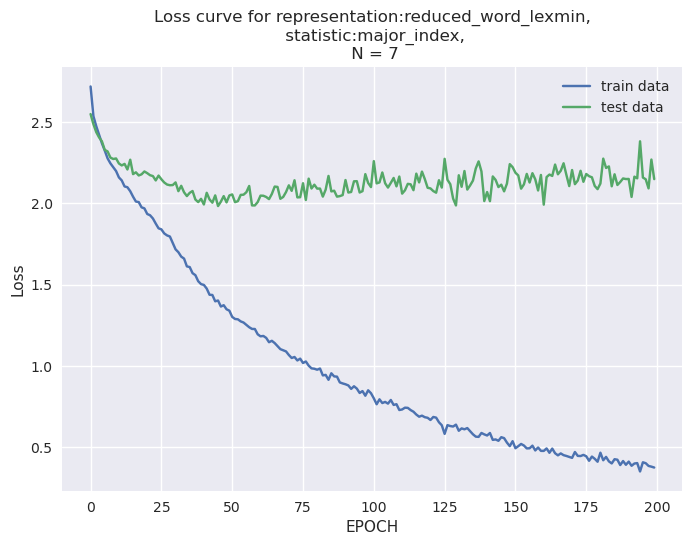

In [107]:
plt.title(f'Loss curve for representation:{representation},\n statistic:{statistic},\n N = {N}')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.plot(all_train_loss, label = 'train data')
plt.plot(all_test_loss, label= 'test data')
plt.legend()
plt.show()

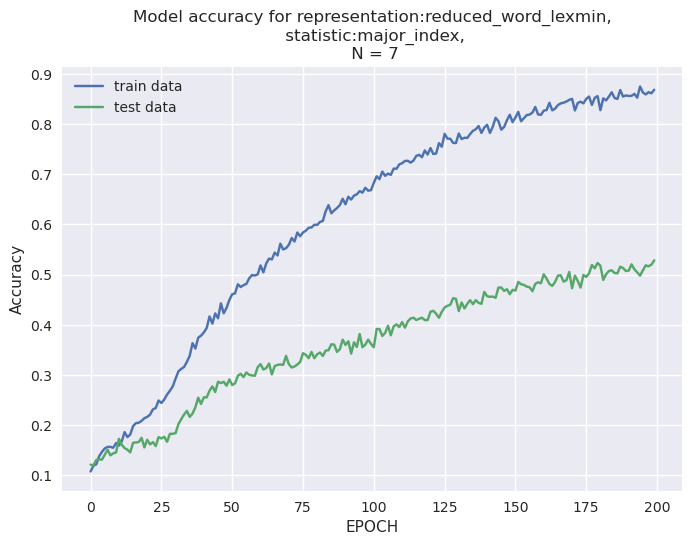

In [108]:
plt.title(f'Model accuracy for representation:{representation},\n statistic:{statistic},\n N = {N}')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(all_train_acc, label = 'train data')
plt.plot(all_test_acc, label= 'test data')
plt.legend()
plt.show()

Notice:
This computer software was prepared by Battelle Memorial Institute, hereinafter the Contractor, under Contract No. DE-AC05-76RL01830 with the Department of Energy (DOE).  All rights in the computer software are reserved by DOE on behalf of the United States Government and the Contractor as provided in the Contract.  You are authorized to use this computer software but it is not to be redistributed.  NEITHER THE GOVERNMENT NOR THE CONTRACTOR MAKES ANY WARRANTY, EXPRESS OR IMPLIED, OR ASSUMES ANY LIABILITY FOR THE USE OF THIS SOFTWARE.  This notice including this sentence must appear on any copies of this computer software.
 
Disclaimer:
This material was prepared as an account of work sponsored by an agency of the
United States Government.  Neither the United States Government nor the United
States Department of Energy, nor Battelle, nor any of their employees, nor any
jurisdiction or organization that has cooperated in the development of these
materials, makes any warranty, express or implied, or assumes any legal
liability or responsibility for the accuracy, completeness, or usefulness or
any information, apparatus, product, software, or process disclosed, or
represents that its use would not infringe privately owned rights.
 
Reference herein to any specific commercial product, process, or service by
trade name, trademark, manufacturer, or otherwise does not necessarily
constitute or imply its endorsement, recommendation, or favoring by the United
States Government or any agency thereof, or Battelle Memorial Institute. The
views and opinions of authors expressed herein do not necessarily state or
reflect those of the United States Government or any agency thereof.
 
                 PACIFIC NORTHWEST NATIONAL LABORATORY
                              operated by
                                BATTELLE
                                for the
                   UNITED STATES DEPARTMENT OF ENERGY
                    under Contract DE-AC05-76RL01830